# RAG Retrieval Enhanced with Document Summaries
In this section, we'll implement an improved approach to our retrieval system by incorporating document summaries. Instead of embedding chunks directly from the documents, we'll create a concise summary for each chunk and use this summary along with the original content in our embedding process.

This approach aims to capture the essence of each document chunk more effectively, potentially leading to improved retrieval performance.

Key steps in this process:

1. We load the original document chunks.
2. For each chunk, we generate a 2-3 sentence summary using OpenAI (or an OpenAI compatible API).
3. We store both the original content and the summary for each chunk in a new json file: data/anthropic_summary_indexed_docs.json

This summary-enhanced approach is designed to provide more context during the embedding and retrieval phases, potentially improving the system's ability to understand and match the most relevant documents to user queries.

In [1]:
## silent setup (-q), may take a while
!pip install openai -q
!pip install --upgrade tiktoken -q
!pip install pandas -q
!pip install numpy -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install -U scikit-learn -q
!pip install sentence-transformers -q
!pip install pyyaml -q

In [2]:
# model configuration
embeddings_model_name = "intfloat/multilingual-e5-large-instruct"; generation_model = "gpt-4o-mini"; judge_model = "gpt-4o-mini"
embeddings_model_name = "jinaai/jina-embeddings-v2-base-en"
model_temperature = 0.2

In [3]:
import os
import getpass
from openai import OpenAI
OPENAI_API_KEY = getpass.getpass("Enter OpenAI API key")
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
# print(os.environ.get("OPENAI_API_KEY"))
client = OpenAI()

Enter OpenAI API key ········


In [6]:
from sentence_transformers import SentenceTransformer
# embeddings_model = SentenceTransformer(embeddings_model_name)
# max_len = embeddings_model.max_seq_length

# try a difference model with longer context window
embeddings_model = SentenceTransformer(
    embeddings_model_name, # switch to en/zh for English or Chinese
    trust_remote_code=True
)

# control your input sequence length up to 8192
embeddings_model.max_seq_length = 4096

# max_word_len = max_len * 0.75
max_word_len = embeddings_model.max_seq_length * 0.75

# print(f"Max Sequence Length of model, {embeddings_model_name}:, {max_len}, about {max_word_len} words")
print(f"Max Sequence Length of model, {embeddings_model_name}:, {embeddings_model.max_seq_length}, about {max_word_len} words")

# run a short test
from sentence_transformers.util import cos_sim
embeddings = embeddings_model.encode([
    'How is the weather today?',
    'What is the current weather like today?'
])
print(cos_sim(embeddings[0], embeddings[1]))

Max Sequence Length of model, jinaai/jina-embeddings-v2-base-en:, 4096, about 3072.0 words
tensor([[0.9341]])


### Generating the Summaries and Storing Them
You can invoke this depending on whether its already available

In [7]:
# TODO, this is for Claud-3-haiku, need to be changed to OpenAI or Llama
import json
from tqdm import tqdm

def generate_summaries(input_file, output_file):
 
    # Load the original documents
    with open(input_file, 'r') as f:
        docs = json.load(f)

    # Prepare the context about the overall knowledge base
    knowledge_base_context = "This is documentation for Anthropic's, a frontier AI lab building Claude, an LLM that excels at a variety of general purpose tasks. These docs contain model details and documentation on Anthropic's APIs."

    summarized_docs = []

    for doc in tqdm(docs, desc="Generating summaries"):
        prompt = f"""
        You are tasked with creating a short summary of the following content from Anthropic's documentation. 

        Context about the knowledge base:
        {knowledge_base_context}

        Content to summarize:
        Heading: {doc['chunk_heading']}
        {doc['text']}

        Please provide a brief summary of the above content in 2-3 sentences. The summary should capture the key points and be concise. We will be using it as a key part of our search pipeline when answering user queries about this content. 

        Avoid using any preamble whatsoever in your response. Statements such as 'here is the summary' or 'the summary is as follows' are prohibited. You should get straight into the summary itself and be concise. Every word matters.
        """

        response = client.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=150,
            messages=[
                {"role": "user", "content": prompt}
            ],
            temperature=0
        )

        summary = response.content[0].text.strip()

        summarized_doc = {
            "chunk_link": doc["chunk_link"],
            "chunk_heading": doc["chunk_heading"],
            "text": doc["text"],
            "summary": summary
        }
        summarized_docs.append(summarized_doc)

    # Save the summarized documents to a new JSON file
    with open(output_file, 'w') as f:
        json.dump(summarized_docs, f, indent=2)

    print(f"Summaries generated and saved to {output_file}")
    
# this is already available, so the call is commented out
# generate_summaries('data/anthropic_docs.json', 'data/anthropic_summary_indexed_docs.json')

### Summary-Enhanced Vector Database Creation (heading + summary + chunk)
Here, we're creating a new vector database that incorporates our summary-enhanced document chunks. This approach combines the original text, the chunk heading, and the newly generated summary into a single text for embedding.

Key features of this process:

1. We create embeddings for the combined text (heading + summary + original content) using the Voyage AI API.
2. The embeddings and full metadata (including summaries) are stored in our vector database.
3. We implement caching mechanisms to improve efficiency in repeated queries.
4. The database is saved to disk for persistence and quick loading in future sessions.

This summary-enhanced approach aims to create more informative embeddings, potentially leading to more accurate and contextually relevant document retrieval.

In [8]:
import os
import numpy as np
import pickle
import json

class SummaryEnhancedVectorDB:
    def __init__(self, name, api_key=None):
        self.name = name
        self.embeddings = []
        self.metadata = []
        self.query_cache = {}
        self.db_path = f"./data/{name}/summary_indexed_vector_db.pkl"

    def _embed_and_store(self, texts, data):
        """not called for now"""
        batch_size = 128
        result = [
            embeddings_model.encode(texts[i : i + batch_size], normalize_embeddings=True)
            for i in range(0, len(texts), batch_size)
        ]
        self.embeddings = [embedding for batch in result for embedding in batch]
        self.metadata = data
        
    def load_data(self, data_file):
        # Check if the vector database is already loaded
        if self.embeddings and self.metadata:
            print("Vector database is already loaded. Skipping data loading.")
            return
        # Check if vector_db.pkl exists
        if os.path.exists(self.db_path):
            print(f"Loading vector database from file: {self.db_path}.")
            self.load_db()
            return
            
        # well, if not...
        print(f'file {self.db_path} does not exist')
        with open(data_file, 'r') as f:
            data = json.load(f)
            
        # Embed Chunk Heading + Text + Summary Together
        texts = [f"{item['chunk_heading']}\n\n{item['text']}\n\n{item['summary']}" for item in data]
        print(f'****Total Chunks: {len(texts)}')
        texts_exceeding_max_len = [s for s in texts if len(s) > max_word_len]
        print(f'****Chunks greater that {max_word_len} words: {len(texts_exceeding_max_len)}')
        
        # Embed more than 128 documents with a for loop
        batch_size = 128
        result = [
            embeddings_model.encode(texts[i : i + batch_size], normalize_embeddings=True)
            for i in range(0, len(texts), batch_size)
        ]

        # Flatten the embeddings
        self.embeddings = [embedding for batch in result for embedding in batch]
        self.metadata = data  # Store the entire item as metadata
        self.save_db()
        # Save the vector database to disk
        print("Vector database loaded and saved.")

    def search(self, query, k=3, similarity_threshold=0.75):
        query_embedding = None
        if query in self.query_cache:
            # print(f'found in cache!')
            query_embedding = np.array(self.query_cache[query])  #
            # print(f'type:{type(query_embedding)}')
        else:
            query_embedding = embeddings_model.encode(query, normalize_embeddings=True)
            # print(f'query embedding:\n {query_embedding}')
            self.query_cache[query] = query_embedding.tolist()

        if not self.embeddings:
            raise ValueError("No data loaded in the vector database.")

        similarities = np.dot(self.embeddings, query_embedding)
        top_indices = np.argsort(similarities)[::-1]
        top_examples = []
        
        for idx in top_indices:
            if similarities[idx] >= similarity_threshold:
                example = {
                    "metadata": self.metadata[idx],
                    "similarity": similarities[idx],
                }
                top_examples.append(example)
                
                if len(top_examples) >= k:
                    break
        # self.save_db()
        return top_examples
    
    def save_db(self):
        data = {
            "embeddings": self.embeddings,
            "metadata": self.metadata,
            "query_cache": json.dumps(self.query_cache),
        }

        # Ensure the directory exists
        print(f'Saving DB in: {self.db_path}')
        os.makedirs(os.path.dirname(self.db_path), exist_ok=True)
        
        with open(self.db_path, "wb") as file:
            pickle.dump(data, file)

    def load_db(self):
        if not os.path.exists(self.db_path):
            raise ValueError("Vector database file not found. Use load_data to create a new database.")
        
        with open(self.db_path, "rb") as file:
            data = pickle.load(file)
        
        self.embeddings = data["embeddings"]
        self.metadata = data["metadata"]
        self.query_cache = json.loads(data["query_cache"])

In [9]:
#previewing our eval dataset
import json

def preview_json(file_path, num_items=3):
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
            
        if isinstance(data, list):
            preview_data = data[:num_items]
        elif isinstance(data, dict):
            preview_data = dict(list(data.items())[:num_items])
        else:
            print(f"Unexpected data type: {type(data)}. Cannot preview.")
            return
        
        print(f"Preview of the first {num_items} items from {file_path}:")
        print(json.dumps(preview_data, indent=2))
        print(f"\nTotal number of items: {len(data)}")
        
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except json.JSONDecodeError:
        print(f"Invalid JSON in file: {file_path}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

preview_json('evaluation/docs_evaluation_dataset.json')


Preview of the first 3 items from evaluation/docs_evaluation_dataset.json:
[
  {
    "id": "efc09699",
    "question": "How can you create multiple test cases for an evaluation in the Anthropic Evaluation tool?",
    "correct_chunks": [
      "https://docs.anthropic.com/en/docs/test-and-evaluate/eval-tool#creating-test-cases",
      "https://docs.anthropic.com/en/docs/build-with-claude/develop-tests#building-evals-and-test-cases"
    ],
    "correct_answer": "To create multiple test cases in the Anthropic Evaluation tool, click the 'Add Test Case' button, fill in values for each variable in your prompt, and repeat the process to create additional test case scenarios."
  },
  {
    "id": "1305ea00",
    "question": "What embeddings provider does Anthropic recommend for customized domain-specific models, and what capabilities does this provider offer?",
    "correct_chunks": [
      "https://docs.anthropic.com/en/docs/build-with-claude/embeddings#before-implementing-embeddings",
      "h

### Enhanced Retrieval Using Summary-Enhanced Embeddings
In this section, we implement the retrieval process using our new summary-enhanced vector database. This approach leverages the enhanced embeddings we created, which incorporate document summaries along with the original content.

Key aspects of this updated retrieval process:

1. We search the vector database using the query embedding, retrieving the top k most similar documents.
2. For each retrieved document, we include the chunk heading, summary, and full text in the context provided to the LLM.
3. This enriched context is then used to generate an answer to the user's query.

By including summaries in both the embedding and retrieval phases, we aim to provide the LLM with a more comprehensive and focused context. This could potentially lead to more accurate and relevant answers, as the LLM has access to both a concise overview (the summary) and the detailed information (the full text) for each relevant document chunk.

In [10]:
import json
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm
import logging
from typing import Callable, List, Dict, Any, Tuple, Set

def retrieve_similar_level_two(query, db):
    # print(f'_______Query used for retrieval________:\n {query}')
    results = db.search(query, k=3)
    context = ""
    for i, result in enumerate(results):
        chunk = result['metadata']
        # show model all 3 items; heading, text, summary
        context += f"\n <document> \n Heading:\n{chunk['chunk_heading']}\n\nText:\n {chunk['text']} \n\nSummary: \n {chunk['summary']} \n </document> \n" 
    
        # print(f'-----------start retrieval {i} --------------')
        # print(f"__Retrieved results heading__:\n{result['metadata']['chunk_heading']}")
        # print(f"__Retrieved results text__:\n{result['metadata']['text']}")
        # print(f"__Retrieved results summary__:\n{result['metadata']['summary']}")
        # print(f'-----------end retrieval {i} ----------------')
        
    return results, context

def construct_prompt(query, context):    
    prompt = f"""
    You have been tasked with helping us to answer the following query: 
    <query>
    {query}
    </query>
    You have access to the following documents which are meant to provide context as you answer the query:
    <documents>
    {context}
    </documents>
    Please remain faithful to the underlying context, and only deviate from it if you are 100% sure that you know the answer already. 
    Answer the question now, and avoid providing preamble such as 'Here is the answer', etc
    """

    return prompt

def answer_query_from_context_level_two(query, db):
    documents, context = retrieve_similar_level_two(query, db)
    # print(f'query + context:\n{construct_prompt(query, context)}')
    completion = client.chat.completions.create(
    model=generation_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": construct_prompt(query, context)
            }
        ],
        temperature=model_temperature
    )
    return completion.choices[0].message.content

# Load the evaluation dataset
with open('evaluation/docs_evaluation_dataset.json', 'r') as f:
    eval_data = json.load(f)

# Initialize the SummaryEnhancedVectorDB
level_two_db = SummaryEnhancedVectorDB("anthropic_docs_v2")
level_two_db.load_data('data/anthropic_summary_indexed_docs.json')
level_two_db.save_db()

# # Load the Anthropic documentation
# with open('data/anthropic_docs.json', 'r') as f:
#     anthropic_docs = json.load(f)

# test
#query = "What embeddings provider does Anthropic recommend for customized domain-specific models, and what capabilities does this provider offer?"
query = "What are two ways that Claude for Sheets can improve prompt engineering workflows compared to using chained prompts?"
test_results, test_contexts = retrieve_similar_level_two(query, level_two_db)
# for i, test_result in enumerate(test_results):
#     print(f'ith:{i}\n {test_result}')

file ./data/anthropic_docs_v2/summary_indexed_vector_db.pkl does not exist
****Total Chunks: 232
****Chunks greater that 3072.0 words: 63


OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB. GPU 0 has a total capacity of 15.77 GiB of which 102.44 MiB is free. Process 2369990 has 3.92 GiB memory in use. Process 2379559 has 11.74 GiB memory in use. Of the allocated memory 11.30 GiB is allocated by PyTorch, and 77.63 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Defining Our Metric Calculation Functions

In [14]:
def calculate_mrr(retrieved_links: List[str], correct_links: Set[str]) -> float:
    for i, link in enumerate(retrieved_links, 1):
        if link in correct_links:
            return 1 / i
    return 0

def evaluate_retrieval(retrieval_function: Callable, evaluation_data: List[Dict[str, Any]], db: Any) -> Tuple[float, float, float, float, List[float], List[float], List[float]]:
    precisions = []
    recalls = []
    mrrs = []
    
    for i, item in enumerate(tqdm(evaluation_data, desc="Evaluating Retrieval")):
        try:
            retrieved_chunks, _ = retrieval_function(item['question'], db)
            retrieved_links = [chunk['metadata'].get('chunk_link', chunk['metadata'].get('url', '')) for chunk in retrieved_chunks]
        except Exception as e:
            logging.error(f"Error in retrieval function: {e}")
            continue

        correct_links = set(item['correct_chunks'])
        
        true_positives = len(set(retrieved_links) & correct_links)
        precision = true_positives / len(retrieved_links) if retrieved_links else 0
        recall = true_positives / len(correct_links) if correct_links else 0
        mrr = calculate_mrr(retrieved_links, correct_links)
        
        precisions.append(precision)
        recalls.append(recall)
        mrrs.append(mrr)
        
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(evaluation_data)} items. Current Avg Precision: {sum(precisions) / len(precisions):.4f}, Avg Recall: {sum(recalls) / len(recalls):.4f}, Avg MRR: {sum(mrrs) / len(mrrs):.4f}")
    
    avg_precision = sum(precisions) / len(precisions) if precisions else 0
    avg_recall = sum(recalls) / len(recalls) if recalls else 0
    avg_mrr = sum(mrrs) / len(mrrs) if mrrs else 0
    f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
    
    return avg_precision, avg_recall, avg_mrr, f1, precisions, recalls, mrrs

import tiktoken
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """For OpenAI models, returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

def evaluate_end_to_end(answer_query_function, db, eval_data):
    correct_answers = 0
    results = []
    total_questions = len(eval_data)
    
    for i, item in enumerate(tqdm(eval_data, desc="Evaluating End-to-End")):
        query = item['question']
        correct_answer = item['correct_answer']
        generated_answer = answer_query_function(query, db) # ??
        
        comparision_prompt = f"""
        You are an AI assistant tasked with evaluating the correctness of answers to questions about Anthropic's documentation.
        
        Question: {query}
        
        Correct Answer: {correct_answer}
        
        Generated Answer: {generated_answer}
        
        Is the Generated Answer correct based on the Correct Answer? You should pay attention to the substance of the answer, and ignore minute details that may differ. 
        
        Small differences or changes in wording don't matter. If the generated answer and correct answer are saying essentially the same thing then that generated answer should be marked correct. 
        
        However, if there is any critical piece of information which is missing from the generated answer in comparison to the correct answer, then we should mark this as incorrect. 
        
        Finally, if there are any direct contradictions between the correct answer and generated answer, we should deem the generated answer to be incorrect.
        
        Respond in the following XML format (don't prefix with xml):
        <evaluation>
        <content>
        <explanation>Your explanation here</explanation>
        <is_correct>true/false</is_correct>
        </content>
        </evaluation>
        """
        
        nb_tokens = num_tokens_from_string(comparision_prompt, "o200k_base")  # note, this encoding name is for gpt-4o, gpt-4o-mini
        
        try:
            response = client.chat.completions.create(
                model=judge_model,
                messages=[
                    {"role": "system", "content": "You are a helpful judge."},
                    {"role": "user", "content": comparision_prompt}
                ],
                temperature=model_temperature,
            )
            response_text = str(response.choices[0].message.content)
            print(f'Number of query tokens: {nb_tokens}, Query:\n{query}')
            print(f'__Correct answer__:\n{correct_answer}')
            print(f'__Generated answer__:\n{generated_answer}')
            print(f'__Response from judge LLM__:\n{response_text}')
            
            evaluation = ET.fromstring(response_text)
            is_correct_value = evaluation.find(".//is_correct").text
            
            is_correct = is_correct_value == 'true'
            
            if is_correct:
                correct_answers += 1
            results.append(is_correct)
            
            logging.info(f"Question {i + 1}/{total_questions}: {query}")
            logging.info(f"Correct: {is_correct}")
            logging.info("---")
            
        except ET.ParseError as e:
            logging.error(f"XML parsing error: {e}")
            is_correct = 'true' in response_text.lower()
            results.append(is_correct)
        except Exception as e:
            logging.error(f"Unexpected error: {e}")
            results.append(False)
        
        if (i + 1) % 10 == 0:
            current_accuracy = correct_answers / (i + 1)
            print(f"Processed {i + 1}/{total_questions} questions. Current Accuracy: {current_accuracy:.4f}")
        # time.sleep(2)
    accuracy = correct_answers / total_questions
    return accuracy, results



In [15]:
# Initialize the SummaryIndexedVectorDB
# level_two_db = SummaryEnhancedVectorDB("anthropic_docs_v2")
# level_two_db.load_data('data/anthropic_summary_indexed_docs.json')

import pandas as pd

# Run the evaluations
eval_data_range = eval_data[0:100]
avg_precision, avg_recall, avg_mrr, f1, precisions, recalls, mrrs  = evaluate_retrieval(retrieve_similar_level_two, eval_data_range, level_two_db)
e2e_accuracy, e2e_results = evaluate_end_to_end(answer_query_from_context_level_two, level_two_db, eval_data_range)

# Create a DataFrame
df = pd.DataFrame({
    'question': [item['question'] for item in eval_data_range],
    'retrieval_precision': precisions,
    'retrieval_recall': recalls,
    'retrieval_mrr': mrrs,
    'e2e_correct': e2e_results
})

# Save to CSV
from pathlib import Path
csv_dir = Path('evaluation/csvs')
csv_file_name = Path('evaluation_results_summary_enhanced.csv')
df.to_csv(csv_dir / csv_file_name, index=False)
print(f"Detailed results saved to {csv_dir/ csv_file_name}")

# Print the results
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average MRR: {avg_mrr:.4f}")
print(f"Average F1: {f1:.4f}")
print(f"End-to-End Accuracy: {e2e_accuracy:.4f}")

# Save the results to a json file
json_dir = Path("evaluation/json_results")
result_file_name = Path("evaluation_results_summary_enhanced.json")
Path(json_dir).mkdir(parents=True, exist_ok=True)
with open(json_dir / result_file_name, 'w') as f:
    json.dump({
        "name": "Summary Enhanced",
        "average_precision": avg_precision,
        "average_recall": avg_recall,
        "average_f1": f1,
        "average_mrr": avg_mrr,
        "end_to_end_accuracy": e2e_accuracy
    }, f, indent=2)

print(f"Evaluation complete. Results saved to {json_dir / result_file_name}, {csv_dir/ csv_file_name}")

Evaluating Retrieval:  15%|█▌        | 15/100 [00:00<00:01, 47.60it/s]

Processed 10/100 items. Current Avg Precision: 0.4667, Avg Recall: 0.7500, Avg MRR: 0.9500


Evaluating Retrieval:  25%|██▌       | 25/100 [00:00<00:01, 48.12it/s]

Processed 20/100 items. Current Avg Precision: 0.3667, Avg Recall: 0.6000, Avg MRR: 0.7417


Evaluating Retrieval:  37%|███▋      | 37/100 [00:00<00:01, 52.70it/s]

Processed 30/100 items. Current Avg Precision: 0.4111, Avg Recall: 0.6500, Avg MRR: 0.7611
Processed 40/100 items. Current Avg Precision: 0.4167, Avg Recall: 0.6542, Avg MRR: 0.7833


Evaluating Retrieval:  58%|█████▊    | 58/100 [00:01<00:00, 58.71it/s]

Processed 50/100 items. Current Avg Precision: 0.4200, Avg Recall: 0.6733, Avg MRR: 0.7733
Processed 60/100 items. Current Avg Precision: 0.4278, Avg Recall: 0.6944, Avg MRR: 0.8111


Evaluating Retrieval:  78%|███████▊  | 78/100 [00:01<00:00, 60.10it/s]

Processed 70/100 items. Current Avg Precision: 0.4048, Avg Recall: 0.6631, Avg MRR: 0.7786
Processed 80/100 items. Current Avg Precision: 0.4208, Avg Recall: 0.6865, Avg MRR: 0.7938


Evaluating Retrieval: 100%|██████████| 100/100 [00:01<00:00, 56.23it/s]


Processed 90/100 items. Current Avg Precision: 0.4222, Avg Recall: 0.6824, Avg MRR: 0.7833
Processed 100/100 items. Current Avg Precision: 0.4033, Avg Recall: 0.6508, Avg MRR: 0.7633


Evaluating End-to-End:   1%|          | 1/100 [00:04<06:53,  4.18s/it]

Number of query tokens: 416, Query:
How can you create multiple test cases for an evaluation in the Anthropic Evaluation tool?
__Correct answer__:
To create multiple test cases in the Anthropic Evaluation tool, click the 'Add Test Case' button, fill in values for each variable in your prompt, and repeat the process to create additional test case scenarios.
__Generated answer__:
To create multiple test cases for evaluation in the Anthropic Evaluation tool, follow these steps:

1. Access the Evaluation screen after composing your prompt in the Anthropic Console.
2. Click the ‘Add Test Case’ button to add a new test case.
3. Fill in the values for each variable in your prompt. Ensure your prompt includes at least 1-2 dynamic variables using the double brace syntax ({{variable}}) to facilitate this.
4. Repeat the process to create as many test cases as needed for your evaluation scenarios.

If you later update your original prompt text, you can re-run the entire evaluation suite against th

Evaluating End-to-End:   1%|          | 1/100 [00:04<07:31,  4.56s/it]


KeyboardInterrupt: 

In [11]:
!pip install matplotlib -q
!pip install seaborn -q
from utils.plot_perf import plot_performance

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


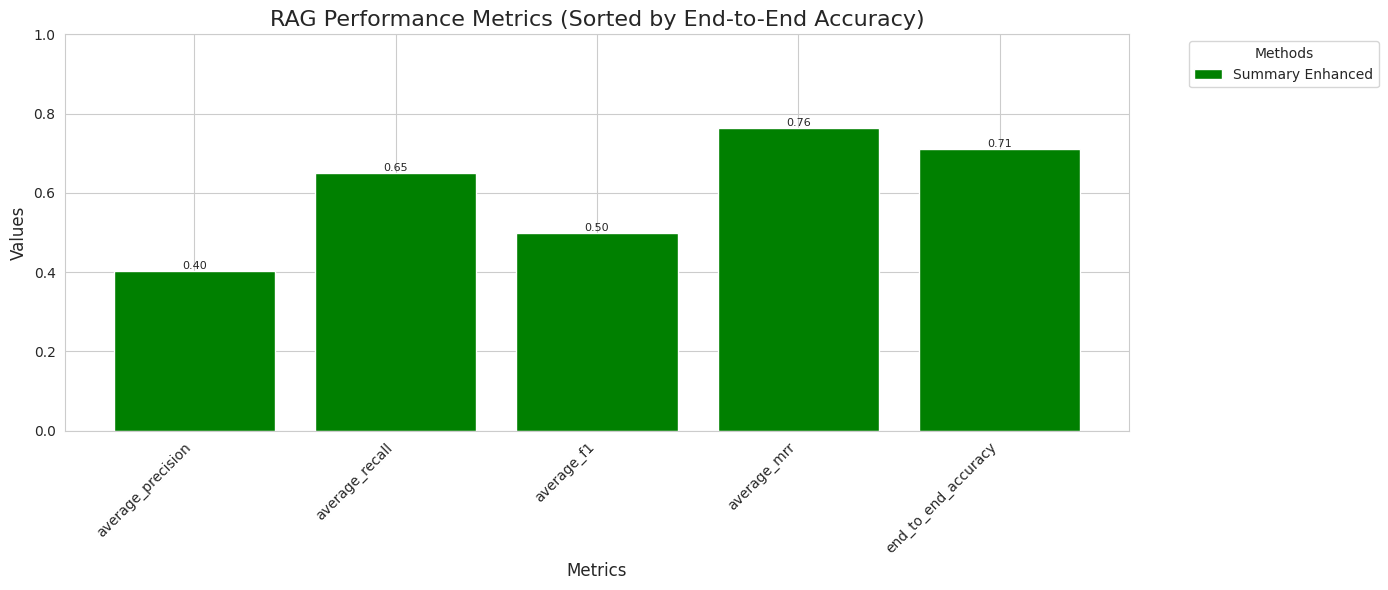

In [12]:
#let's visualize our accuracy
# plot_performance('evaluation/json_results', ['Basic RAG', 'Summary Enhanced'], colors=['skyblue', 'green'])
plot_performance('evaluation/json_results', [ 'Summary Enhanced'], colors=['green'])